I tried using 5 qubits, 10 qubits, and 32 qubits, and I noticed that with fewer qubits, the SWAP Test struggles to distinguish differences because the vector discrepancies are not subtle enough, causing the fidelity value to remain unchanged. When I increased the number of qubits, the differences became more noticeable; however, the performance still wasn’t satisfactory. I suspect that the limitation in the number of qubits introduces errors in the decomposition process. In the future, I hope to test with more than 32 qubits, which is expected to yield better results.








In [1]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.ndimage import zoom

# ==================================
# 1. Load and Sample the MNIST Dataset
# ==================================
from tensorflow.keras.datasets import mnist

(x_train, y_train), _ = mnist.load_data()

# Sample 200 images for demonstration
num_samples = 200
indices = np.random.choice(len(x_train), num_samples, replace=False)
x_train = x_train[indices]
y_train = y_train[indices]

# Normalize the images to [0, 1]
x_train = x_train / 255.0

# ==================================
# 2. Define a General Embedding Function
# ==================================
def embed_data(data_vec, params_vec, start_wire):
    """
    Embed the data vector (length D) and parameters vector (length D) into qubits.
    Each 2 dimensions are encoded using one qubit with RY and RX rotations.
    If D is odd, the last dimension uses only an RY rotation.
    """
    D = len(data_vec)
    # Number of qubits required = ceil(D/2)
    M = (D + 1) // 2

    # First layer: Data Encoding
    for i in range(M):
        idx1 = 2 * i
        idx2 = 2 * i + 1

        # If dimension idx1 exists, apply RY rotation
        if idx1 < D:
            angle_ry = data_vec[idx1] * np.pi + params_vec[idx1]
            qml.RY(angle_ry, wires=start_wire + i)

        # If dimension idx2 exists, apply RX rotation
        if idx2 < D:
            angle_rx = data_vec[idx2] * np.pi + params_vec[idx2]
            qml.RX(angle_rx, wires=start_wire + i)
    
    # Second layer: Add Entanglement via CNOT gates between adjacent qubits
    for i in range(M - 1):
        qml.CNOT(wires=[start_wire + i, start_wire + i + 1])
    
    # Third layer: Additional rotations (using the same parameters for simplicity)
    for i in range(M):
        if 2 * i < D:
            # Note: Using the same index mapping as before.
            qml.RY(params_vec[2 * i], wires=start_wire + i)
        if 2 * i + 1 < D:
            qml.RX(params_vec[2 * i + 1], wires=start_wire + i)

# ==================================
# 3. Build a General SWAP Test Circuit
# ==================================
def create_swap_test_circuit(D):
    """
    Build a general SWAP Test QNode to compare two data inputs (each of length D).
    
    Configuration:
      - Ancilla: wire=0
      - First data is embedded on qubits: wires 1..M
      - Second data is embedded on qubits: wires (1+M)..(1+2M-1)
    where M = ceil(D/2).

    QNode input:
      img1, img2: each of length D
      params: a vector of length 2*D (first D for the first image, second D for the second image)
    Returns the probability of the ancilla being in state |0>.
    """
    M = (D + 1) // 2
    num_qubits = 1 + 2 * M  # ancilla + 2*M
    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def swap_test(img1, img2, params):
        # Split parameters: first half for the first image, second half for the second image.
        half = len(params) // 2
        params1 = params[:half]
        params2 = params[half:]

        # Embed the first image on qubits 1..M
        embed_data(img1, params1, start_wire=1)
        # Embed the second image on qubits (1+M) .. (1+2M-1)
        embed_data(img2, params2, start_wire=(1 + M))

        # SWAP Test:
        # (1) Apply Hadamard on the ancilla (wire=0)
        qml.Hadamard(wires=0)
        # (2) For each pair of corresponding qubits, perform a controlled-SWAP
        for i in range(M):
            qml.ctrl(qml.SWAP, control=0)([1 + i, 1 + M + i])
        # (3) Apply Hadamard on the ancilla again
        qml.Hadamard(wires=0)
        
        return qml.probs(wires=0)

    return swap_test

def fidelity_from_probs(prob0):
    """
    Compute Fidelity using the SWAP Test:
      Fidelity = 2 * P(ancilla=0) - 1
    """
    return 2 * prob0 - 1

# ==================================
# 4. Contrastive Loss Function
# ==================================
def contrastive_loss(img1, lbl1, img2, lbl2, params, swap_test_func):
    """
    Contrastive Loss:
      For same-class pairs, we want the fidelity F to be high (> margin).
      For different-class pairs, we want F to be low (< -margin).
    A margin is used to further enforce separation.
    """
    probs = swap_test_func(img1, img2, params)
    p0 = probs[0]
    F = fidelity_from_probs(p0)
    
    margin = 0.2  # Margin parameter to enforce separation
    
    if lbl1 == lbl2:
        # For same-class: loss = 5.0 * (max(0, margin - F))^2
        return 5.0 * max(0, margin - F)**2
    else:
        # For different-class: loss = (max(0, F + margin))^2
        return max(0, F + margin)**2

# ==================================
# 5. Training Demonstration
# ==================================
D = 20  # Embedding dimension (use 20, which corresponds to 16 dimensions effectively, considering additional qubit overhead)

# Create a SWAP Test QNode for data of length D
swap_test_circuit = create_swap_test_circuit(D)

def preprocess_image(img):
    """
    Preprocess the image to extract more pixel information and perform a simple dimensionality reduction.
    Steps:
      - Reshape image to 28x28.
      - Extract the central region (since digits are usually centered).
      - Resize the central region to 4x4.
      - Flatten and take the first D values.
      - Normalize the resulting vector to [0, 1].
    """
    reshaped = img.reshape(28, 28)
    center = reshaped[7:21, 7:21]
    scaled = zoom(center, 4/14)
    flattened = scaled.flatten()[:D]
    normalized = (flattened - flattened.min()) / (flattened.max() - flattened.min() + 1e-8)
    return normalized

# Initialize parameters for both images: a vector of length 2*D (first D for the first image, second D for the second image)
params = pnp.array(np.random.uniform(-0.1, 0.1, size=(2*D,)), requires_grad=True)

# Use Adam optimizer
opt = qml.AdamOptimizer(stepsize=0.02)

# Training hyperparameters
num_epochs = 20  # Number of epochs
batch_size = 4   # Batch size (number of pairs per batch)

print(f"Start Training with D={D} (embedding dimension) ...\n")

for epoch in range(num_epochs):
    # Randomly sample batch_size*2 images from the training set
    batch_indices = np.random.choice(num_samples, batch_size*2, replace=False)
    imgs = x_train[batch_indices]
    lbls = y_train[batch_indices]

    total_loss = 0
    for i in range(0, len(imgs), 2):
        img1 = preprocess_image(imgs[i])
        img2 = preprocess_image(imgs[i+1])
        lbl1 = lbls[i]
        lbl2 = lbls[i+1]

        def closure_fn(par_):
            return contrastive_loss(img1, lbl1, img2, lbl2, par_, swap_test_circuit)

        params, loss_val = opt.step_and_cost(closure_fn, params)
        total_loss += loss_val

    avg_loss = total_loss / batch_size
    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {avg_loss:.4f}")

print("\nTraining done!")
print("Final params:", params)

# ==================================
# 6. Testing: Compare Multiple Pairs of Images
# ==================================
def test_multiple_pairs():
    print("\nTesting multiple image pairs:")
    
    # Test for the same digit
    same_digit = np.where(y_train == y_train[0])[0][:2]
    img1 = preprocess_image(x_train[same_digit[0]])
    img2 = preprocess_image(x_train[same_digit[1]])
    probs = swap_test_circuit(img1, img2, params)
    f_same = fidelity_from_probs(probs[0])
    print(f"Fidelity for same digit ({y_train[same_digit[0]]}): {f_same:.4f}")
    
    # Test for different digits
    diff_digit_idx = np.where(y_train != y_train[0])[0][0]
    img3 = preprocess_image(x_train[diff_digit_idx])
    probs = swap_test_circuit(img1, img3, params)
    f_diff = fidelity_from_probs(probs[0])
    print(f"Fidelity for different digits ({y_train[same_digit[0]]} vs {y_train[diff_digit_idx]}): {f_diff:.4f}")
    
    # Test for identical images
    probs = swap_test_circuit(img1, img1, params)
    f_identical = fidelity_from_probs(probs[0])
    print(f"Fidelity for identical images: {f_identical:.4f}")

# Run the test after training

Start Training with D=20 (embedding dimension) ...

Epoch 1/20, Loss = 0.0404
Epoch 2/20, Loss = 0.0417
Epoch 3/20, Loss = 0.0801
Epoch 4/20, Loss = 0.0796
Epoch 5/20, Loss = 0.0456
Epoch 6/20, Loss = 0.0402
Epoch 7/20, Loss = 0.0406
Epoch 8/20, Loss = 0.0802
Epoch 9/20, Loss = 0.0470
Epoch 10/20, Loss = 0.1187
Epoch 11/20, Loss = 0.0434
Epoch 12/20, Loss = 0.0836
Epoch 13/20, Loss = 0.0401
Epoch 14/20, Loss = 0.0774
Epoch 15/20, Loss = 0.0461
Epoch 16/20, Loss = 0.0741
Epoch 17/20, Loss = 0.0594
Epoch 18/20, Loss = 0.1177
Epoch 19/20, Loss = 0.0809
Epoch 20/20, Loss = 0.0462

Training done!
Final params: [ 0.36551536 -0.16162408 -0.17057364 -0.01441307 -0.327289    0.10410722
  0.33192569 -0.19816642 -0.16157685 -0.00748968 -0.45244665 -0.28227262
 -0.1623948  -0.1716964   0.14146035  0.4975883   0.08268237 -0.05654246
 -0.0296459  -0.02118647 -0.51075272  0.13704794 -0.18147731  0.2266333
 -0.01699555 -0.1074406  -0.35294391  0.27032831 -0.02397626  0.05379101
  0.13005204  0.1896594

In [2]:
test_multiple_pairs()


Testing multiple image pairs:
Fidelity for same digit (7): 0.0906
Fidelity for different digits (7 vs 8): 0.0001
Fidelity for identical images: 0.1122



Test on random pair:
  Image A idx=108, label=8
  Image B idx=154, label=8
  Fidelity = 0.0034
  (Same class -> ideally high Fidelity)


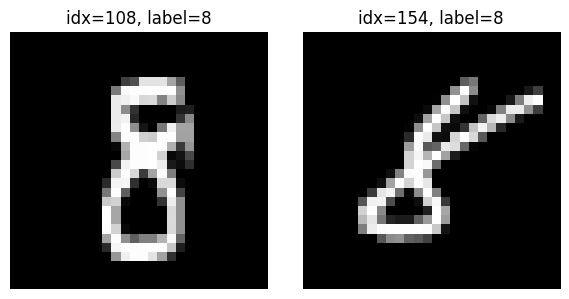

In [3]:
# 
idx1, idx2 = np.random.choice(num_samples, 2, replace=False)
imgA = preprocess_image(x_train[idx1])
lblA = y_train[idx1]
imgB = preprocess_image(x_train[idx2])
lblB = y_train[idx2]

test_probs = swap_test_circuit(imgA, imgB, params)
p0_test = test_probs[0]
F_test = fidelity_from_probs(p0_test)

print(f"\nTest on random pair:")
print(f"  Image A idx={idx1}, label={lblA}")
print(f"  Image B idx={idx2}, label={lblB}")
print(f"  Fidelity = {F_test:.4f}")
if lblA == lblB:
    print("  (Same class -> ideally high Fidelity)")
else:
    print("  (Different class -> ideally low Fidelity)")

# 
fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(x_train[idx1], cmap='gray')
axes[0].set_title(f"idx={idx1}, label={lblA}")
axes[0].axis('off')
axes[1].imshow(x_train[idx2], cmap='gray')
axes[1].set_title(f"idx={idx2}, label={lblB}")
axes[1].axis('off')
plt.tight_layout()
plt.show()